# Assignment1: Time Series Forecasting in Python

1. Stock: Airbnb(ABNB)
2. Feature Selection: 
    - Personal Consumption Expenditures (PCE): This measures consumer spending on goods and services. Since Airbnb's business is directly tied to discretionary travel spending, PCE would be particularly relevant. When consumers have more disposable income and are spending freely, Airbnb bookings tend to increase, potentially boosting revenues and stock performance.
    - 10-Year Treasury Yield: This reflects long-term interest rate expectations and influences mortgage rates. Higher mortgage rates can impact housing availability (as fewer new properties enter the market) and might affect Airbnb hosts' decisions to maintain properties as short-term rentals versus traditional housing. It also impacts Airbnb's cost of capital for its own growth initiatives.
    - Unemployment Rate: A strong labor market generally indicates consumers have stable income and are more likely to spend on travel and experiences. Lower unemployment typically correlates with increased discretionary spending, which could benefit Airbnb's booking volumes and revenue growth. 

## Data Preprocessing

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set paths to your data files
treasury_path = '/Users/leesunny/Desktop/S25_Time series/10_treasury.csv'
pce_path = '/Users/leesunny/Desktop/S25_Time series/PCE.csv'
unemployment_path = '/Users/leesunny/Desktop/S25_Time series/unemployment_rate.csv'
stock_path = '/Users/leesunny/Desktop/S25_Time series/stock price.csv'

# 1. Read and clean Treasury Data
treasury_data = pd.read_csv(treasury_path)
print("Treasury Data - First 5 rows (before cleaning):")
print(treasury_data.head())

# Check the structure of the data
print("\nTreasury data dtypes:")
print(treasury_data.dtypes)
print("\nTreasury data columns:", treasury_data.columns.tolist())

# Make sure observation_date and DGS10 are separate columns
treasury_data['date'] = pd.to_datetime(treasury_data['observation_date'])
# Convert DGS10 to numeric, force errors to NaN
treasury_data['treasury_10y'] = pd.to_numeric(treasury_data['DGS10'], errors='coerce')
treasury_data.set_index('date', inplace=True)

# Now create monthly averages
treasury_monthly = treasury_data['treasury_10y'].resample('ME').median()
print("\nTreasury Monthly - First 5 rows (after cleaning):")
print(treasury_monthly.head())

# 2. Read and clean PCE Data
pce_data = pd.read_csv(pce_path)
print("\nPCE Data - First 5 rows (before cleaning):")
print(pce_data.head())

pce_data['date'] = pd.to_datetime(pce_data['observation_date'])
pce_data['pce'] = pd.to_numeric(pce_data['PCE'], errors='coerce')
pce_data.set_index('date', inplace=True)
pce_monthly = pce_data['pce'].resample('ME').median()
print("\nPCE Monthly - First 5 rows (after cleaning):")
print(pce_monthly.head())

# 3. Read and clean Unemployment Data
unemployment_data = pd.read_csv(unemployment_path)
print("\nUnemployment Data - First 5 rows (before cleaning):")
print(unemployment_data.head())

unemployment_data['date'] = pd.to_datetime(unemployment_data['observation_date'])
unemployment_data['unemployment_rate'] = pd.to_numeric(unemployment_data['UNRATE'], errors='coerce')
unemployment_data.set_index('date', inplace=True)
unemployment_monthly = unemployment_data['unemployment_rate'].resample('ME').median()
print("\nUnemployment Monthly - First 5 rows (after cleaning):")
print(unemployment_monthly.head())

# 4. Read and clean Stock Price Data
stock_data = pd.read_csv(stock_path)
print("\nStock Price Data - First 5 rows (before cleaning):")
print(stock_data.head())

# Check column names
print("\nStock data columns:", stock_data.columns.tolist())

# Handle different possible column names for date and price
date_col = 'Date' if 'Date' in stock_data.columns else stock_data.columns[0]
price_col = None

# Try to identify the price column
possible_price_cols = ['Close/Last', 'Close', 'Adj Close', 'Last']
for col in possible_price_cols:
    if col in stock_data.columns:
        price_col = col
        break

# If no standard price column is found, use the second column as fallback
if price_col is None:
    price_col = stock_data.columns[1]

print(f"Using '{date_col}' as date column and '{price_col}' as price column")

# Convert date and price
stock_data['date'] = pd.to_datetime(stock_data[date_col])
stock_data.set_index('date', inplace=True)

# Handle price data - convert to numeric, removing currency symbols if necessary
if stock_data[price_col].dtype == object:
    stock_data['stock_price'] = stock_data[price_col].replace('[\$,]', '', regex=True).astype(float)
else:
    stock_data['stock_price'] = stock_data[price_col]

# Resample to monthly
stock_monthly = stock_data['stock_price'].resample('ME').median()
print("\nStock Monthly - First 5 rows (after cleaning):")
print(stock_monthly.head())

Treasury Data - First 5 rows (before cleaning):
  observation_date  DGS10
0       2021-01-04   0.93
1       2021-01-05   0.96
2       2021-01-06   1.04
3       2021-01-07   1.08
4       2021-01-08   1.13

Treasury data dtypes:
observation_date     object
DGS10               float64
dtype: object

Treasury data columns: ['observation_date', 'DGS10']

Treasury Monthly - First 5 rows (after cleaning):
date
2021-01-31    1.10
2021-02-28    1.20
2021-03-31    1.62
2021-04-30    1.64
2021-05-31    1.63
Freq: ME, Name: treasury_10y, dtype: float64

PCE Data - First 5 rows (before cleaning):
  observation_date      PCE
0       2021-01-01  15081.5
1       2021-02-01  14984.4
2       2021-03-01  15712.4
3       2021-04-01  15915.0
4       2021-05-01  15950.5

PCE Monthly - First 5 rows (after cleaning):
date
2021-01-31    15081.5
2021-02-28    14984.4
2021-03-31    15712.4
2021-04-30    15915.0
2021-05-31    15950.5
Freq: ME, Name: pce, dtype: float64

Unemployment Data - First 5 rows (before cl

<>:89: SyntaxWarning: invalid escape sequence '\$'
<>:89: SyntaxWarning: invalid escape sequence '\$'
/var/folders/_d/yrj9rxnd26j6fnd0s3xl76n80000gn/T/ipykernel_35110/1957050157.py:89: SyntaxWarning: invalid escape sequence '\$'
  stock_data['stock_price'] = stock_data[price_col].replace('[\$,]', '', regex=True).astype(float)


In [10]:
# Create a single DataFrame with all monthly data
print("\nCreating merged dataset...")
merged_data = pd.DataFrame({
    'stock_price': stock_monthly,
    'treasury_10y': treasury_monthly,
    'pce': pce_monthly,
    'unemployment_rate': unemployment_monthly
})

# Check for missing values
print("\nMissing values in merged dataset:")
print(merged_data.isna().sum())

# Find the common date range where all data is available
first_valid_date = max(
    merged_data['stock_price'].first_valid_index(),
    merged_data['treasury_10y'].first_valid_index(),
    merged_data['pce'].first_valid_index(),
    merged_data['unemployment_rate'].first_valid_index()
)

last_valid_date = min(
    merged_data['stock_price'].last_valid_index(),
    merged_data['treasury_10y'].last_valid_index(),
    merged_data['pce'].last_valid_index(),
    merged_data['unemployment_rate'].last_valid_index()
)

print(f"\nCommon date range: {first_valid_date} to {last_valid_date}")

# Filter to the common date range
merged_data = merged_data.loc[first_valid_date:last_valid_date].copy()

# Check for any remaining missing values and fill them
print("\nMissing values after filtering to common range:")
print(merged_data.isna().sum())

# Fill any remaining missing values using forward fill then backward fill
merged_data = merged_data.fillna(method='ffill').fillna(method='bfill')

# Final dataset
print("\nFinal merged dataset - First 5 rows:")
print(merged_data.head())
print("\nFinal merged dataset - shape:", merged_data.shape)

# Save the merged dataset
merged_data.to_csv('/Users/leesunny/Desktop/S25_Time series/merged_monthly_data.csv')
print("\nMerged dataset saved to: /Users/leesunny/Desktop/S25_Time series/merged_monthly_data.csv")


Creating merged dataset...

Missing values in merged dataset:
stock_price          0
treasury_10y         3
pce                  3
unemployment_rate    2
dtype: int64

Common date range: 2021-01-31 00:00:00 to 2025-01-31 00:00:00

Missing values after filtering to common range:
stock_price          0
treasury_10y         0
pce                  0
unemployment_rate    0
dtype: int64

Final merged dataset - First 5 rows:
            stock_price  treasury_10y      pce  unemployment_rate
date                                                             
2021-01-31      169.990          1.10  15081.5                6.4
2021-02-28      199.880          1.20  14984.4                6.2
2021-03-31      187.140          1.62  15712.4                6.1
2021-04-30      177.680          1.64  15915.0                6.1
2021-05-31      140.325          1.63  15950.5                5.8

Final merged dataset - shape: (49, 4)

Merged dataset saved to: /Users/leesunny/Desktop/S25_Time series/merged_mon

/var/folders/_d/yrj9rxnd26j6fnd0s3xl76n80000gn/T/ipykernel_35110/310187704.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data = merged_data.fillna(method='ffill').fillna(method='bfill')


## Part1: Assess the relationship between factors

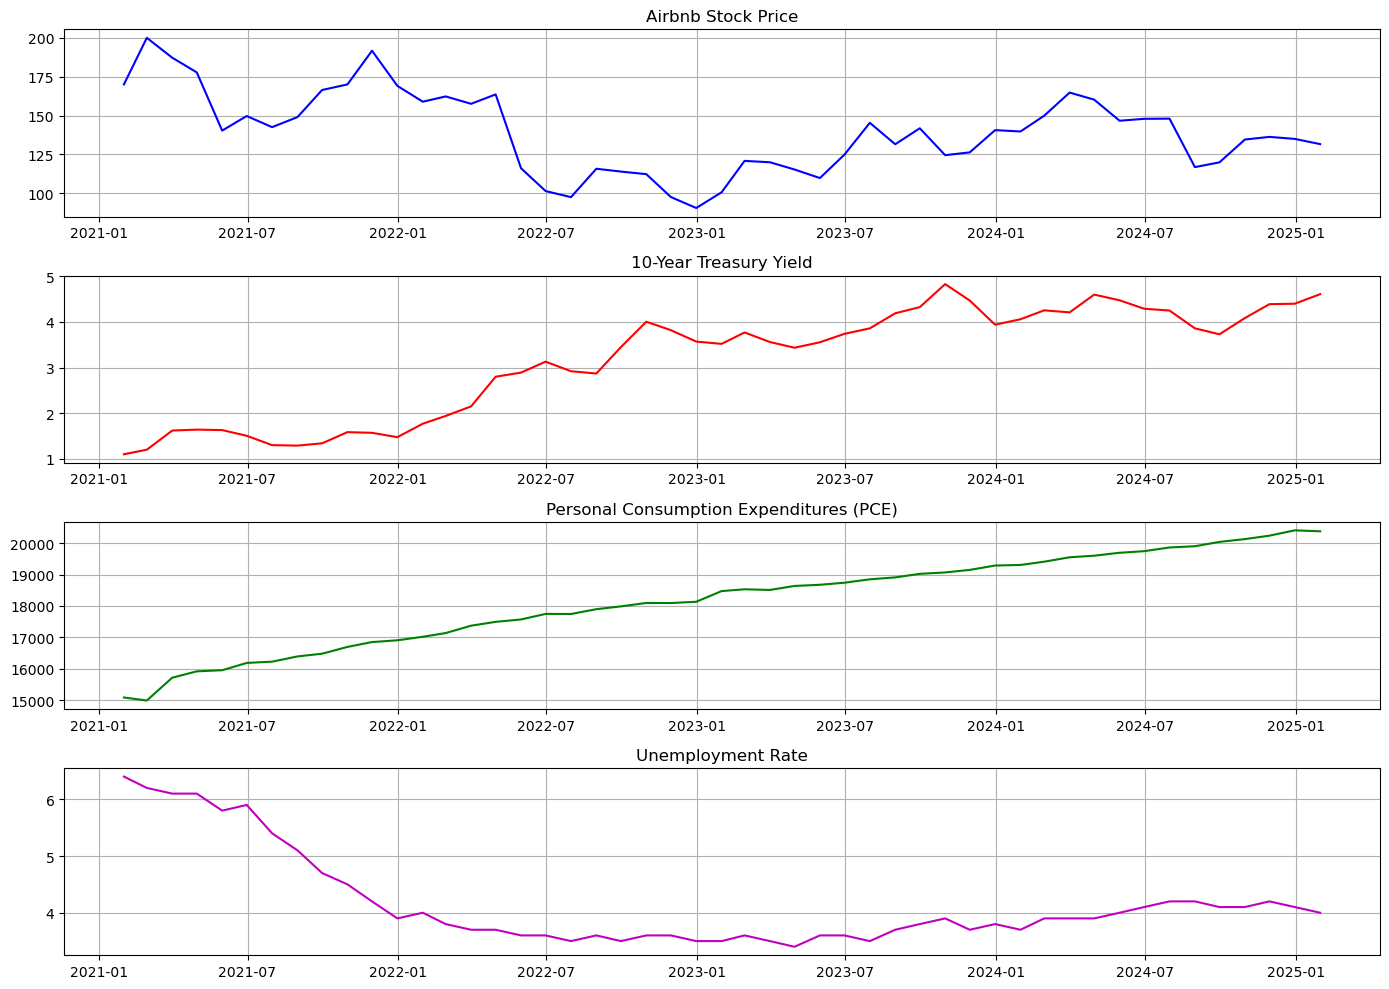


Correlation Matrix:
                   stock_price  treasury_10y       pce  unemployment_rate
stock_price           1.000000     -0.527580 -0.453141           0.610932
treasury_10y         -0.527580      1.000000  0.933098          -0.654609
pce                  -0.453141      0.933098  1.000000          -0.659457
unemployment_rate     0.610932     -0.654609 -0.659457           1.000000


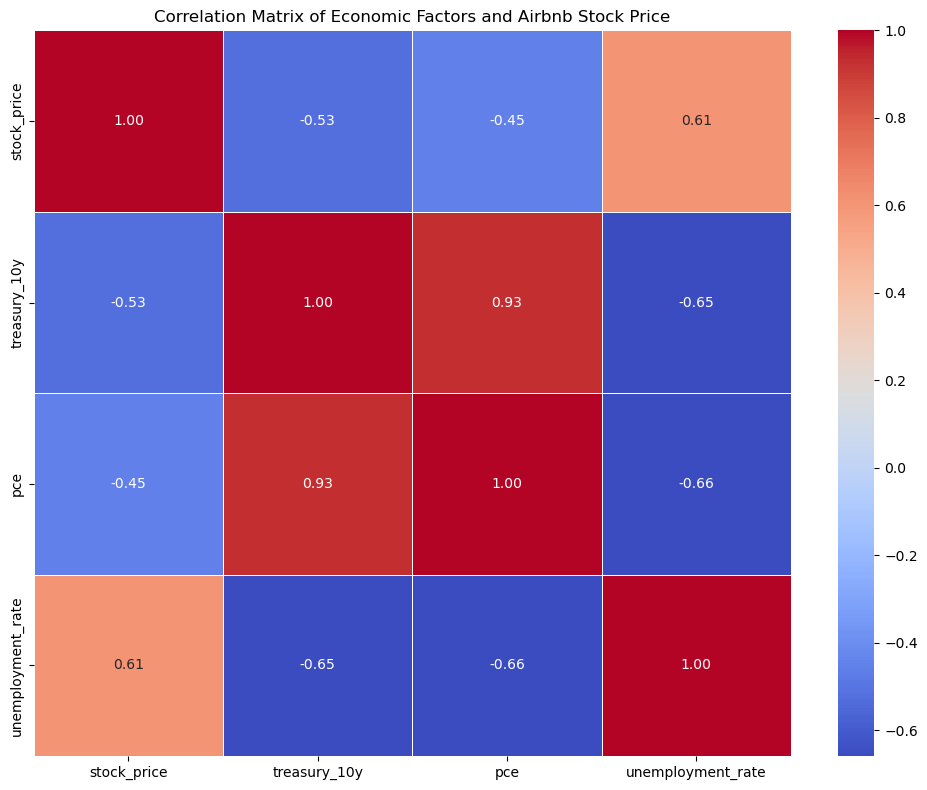

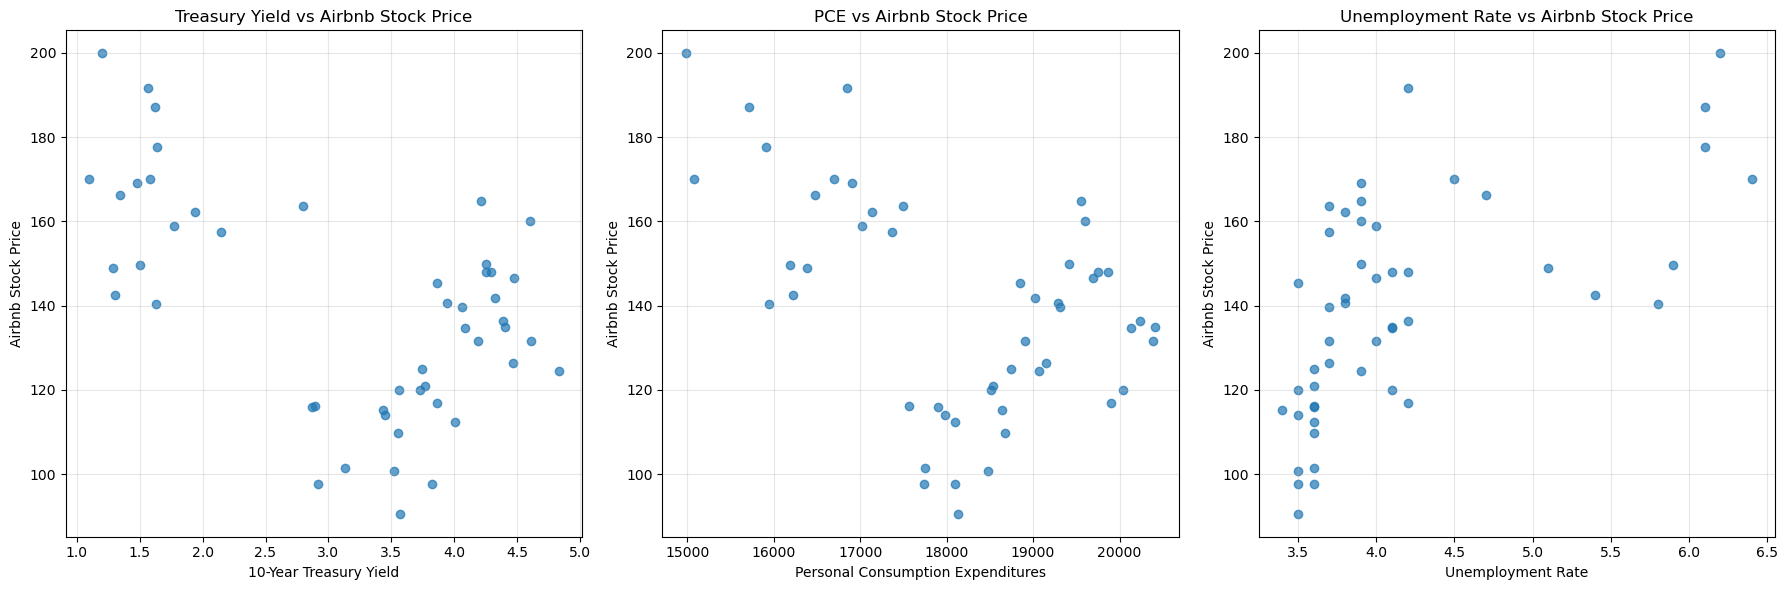

In [13]:
# Visualize the time series
plt.figure(figsize=(14, 10))

# Plot each variable
plt.subplot(4, 1, 1)
plt.plot(merged_data.index, merged_data['stock_price'], 'b-')
plt.title('Airbnb Stock Price')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(merged_data.index, merged_data['treasury_10y'], 'r-')
plt.title('10-Year Treasury Yield')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(merged_data.index, merged_data['pce'], 'g-')
plt.title('Personal Consumption Expenditures (PCE)')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(merged_data.index, merged_data['unemployment_rate'], 'm-')
plt.title('Unemployment Rate')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print correlation matrix
print("\nCorrelation Matrix:")
correlation_matrix = merged_data.corr()
print(correlation_matrix)

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Economic Factors and Airbnb Stock Price')
plt.tight_layout()
plt.show()

# Create scatter plots to visualize relationships
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot for Treasury Yield vs Stock Price
axes[0].scatter(merged_data['treasury_10y'], merged_data['stock_price'], alpha=0.7)
axes[0].set_xlabel('10-Year Treasury Yield')
axes[0].set_ylabel('Airbnb Stock Price')
axes[0].set_title('Treasury Yield vs Airbnb Stock Price')
axes[0].grid(True, alpha=0.3)

# Scatter plot for PCE vs Stock Price
axes[1].scatter(merged_data['pce'], merged_data['stock_price'], alpha=0.7)
axes[1].set_xlabel('Personal Consumption Expenditures')
axes[1].set_ylabel('Airbnb Stock Price')
axes[1].set_title('PCE vs Airbnb Stock Price')
axes[1].grid(True, alpha=0.3)

# Scatter plot for Unemployment Rate vs Stock Price
axes[2].scatter(merged_data['unemployment_rate'], merged_data['stock_price'], alpha=0.7)
axes[2].set_xlabel('Unemployment Rate')
axes[2].set_ylabel('Airbnb Stock Price')
axes[2].set_title('Unemployment Rate vs Airbnb Stock Price')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Feature Finding and Insights

1. 10-Year Treasury Yield (-0.527580)

    - Moderate predictor: This correlation indicates a substantial negative relationship
    - The moderate-to-strong negative correlation suggests that the 10-year Treasury yield could be a reasonably good predictor of Airbnb stock movements
    - When interest rates rise (as reflected in higher Treasury yields), Airbnb's stock tends to fall
    - This aligns with financial theory, as higher interest rates typically reduce stock valuations

2. Personal Consumption Expenditures (PCE) (-0.453141)
    
    - Moderate predictor: This correlation shows a notable negative relationship
    - The negative direction is somewhat counterintuitive, as one might expect higher consumer spending to benefit Airbnb
    - This could indicate that PCE is capturing other economic factors like inflation rather than discretionary travel spending specifically
    - While useful, it may be less reliable than the other indicators

3. Unemployment Rate (0.610932)

    - Strong predictor: This is the strongest correlation among your variables
    - The positive direction is unexpected (higher unemployment associated with higher stock price)
    - This unusual relationship might reflect specific conditions during the pandemic period
    - Despite the unexpected direction, the strong correlation suggests it could be a valuable predictor

**Overall Assessment**:

    - All three variables show significant correlations with Airbnb's stock price (all above 0.45 in absolute value)
    - The unemployment rate shows the strongest relationship, followed by Treasury yield, then PCE
    - The directions of these relationships warrant careful interpretation

## Part2: Univariate forecast to predict the stock price

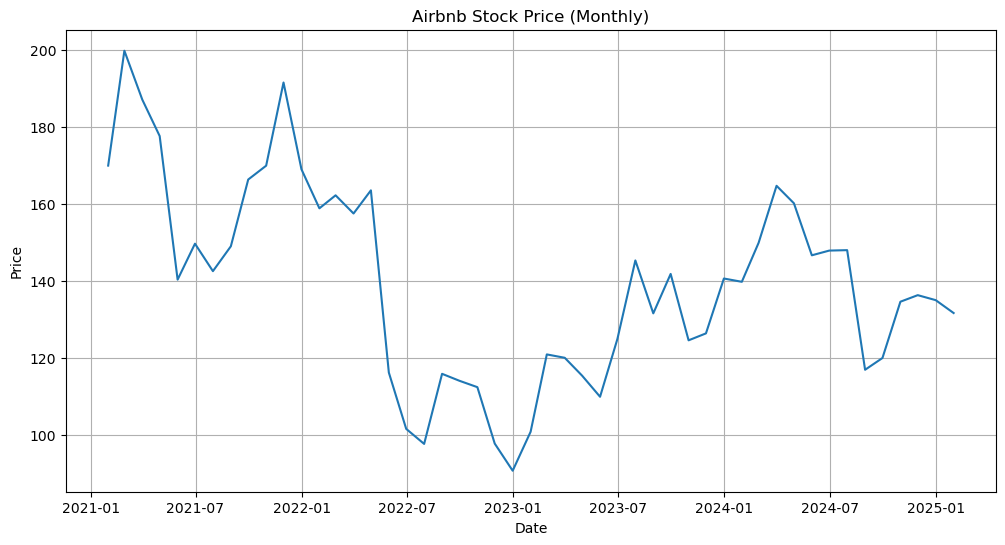

Training data: 2021-01-31 00:00:00 to 2024-03-31 00:00:00, 39 observations
Testing data: 2024-04-30 00:00:00 to 2025-01-31 00:00:00, 10 observations
Fitting Simple Exponential Smoothing...
Fitting Holt's Linear Trend...
Fitting Holt's Exponential Trend...
Fitting Additive Holt-Winters...


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Fitting Multiplicative Holt-Winters...
Fitting Damped Trend...
Fitting Damped Trend Additive Seasonal...


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Fitting Damped Trend Multiplicative Seasonal...

Model Evaluation Results:
                                  Model       RMSE        MAE       MAPE   Theil_U      MASE
0          Simple Exponential Smoothing  29.738932  26.913358  20.576378  1.000000  3.457572
1                   Holt's Linear Trend  28.874862  26.075494  19.947108  0.997028  3.349931
2              Holt's Exponential Trend  23.084246  20.314346  15.618889  0.979721  2.609794
3                 Additive Holt-Winters  15.825712  13.723862  10.502064  1.180863  1.763111
4           Multiplicative Holt-Winters  16.105385  14.382644  10.901902  1.204651  1.847745
5                          Damped Trend  28.634715  25.808691  19.751698  0.996685  3.315655
6        Damped Trend Additive Seasonal  17.283015  15.032126  11.548031  1.182518  1.931184
7  Damped Trend Multiplicative Seasonal  17.458149  15.712480  11.954074  1.209355  2.018590

Best models by metric:
RMSE: Additive Holt-Winters
MAE: Additive Holt-Winters
MAPE: Add

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


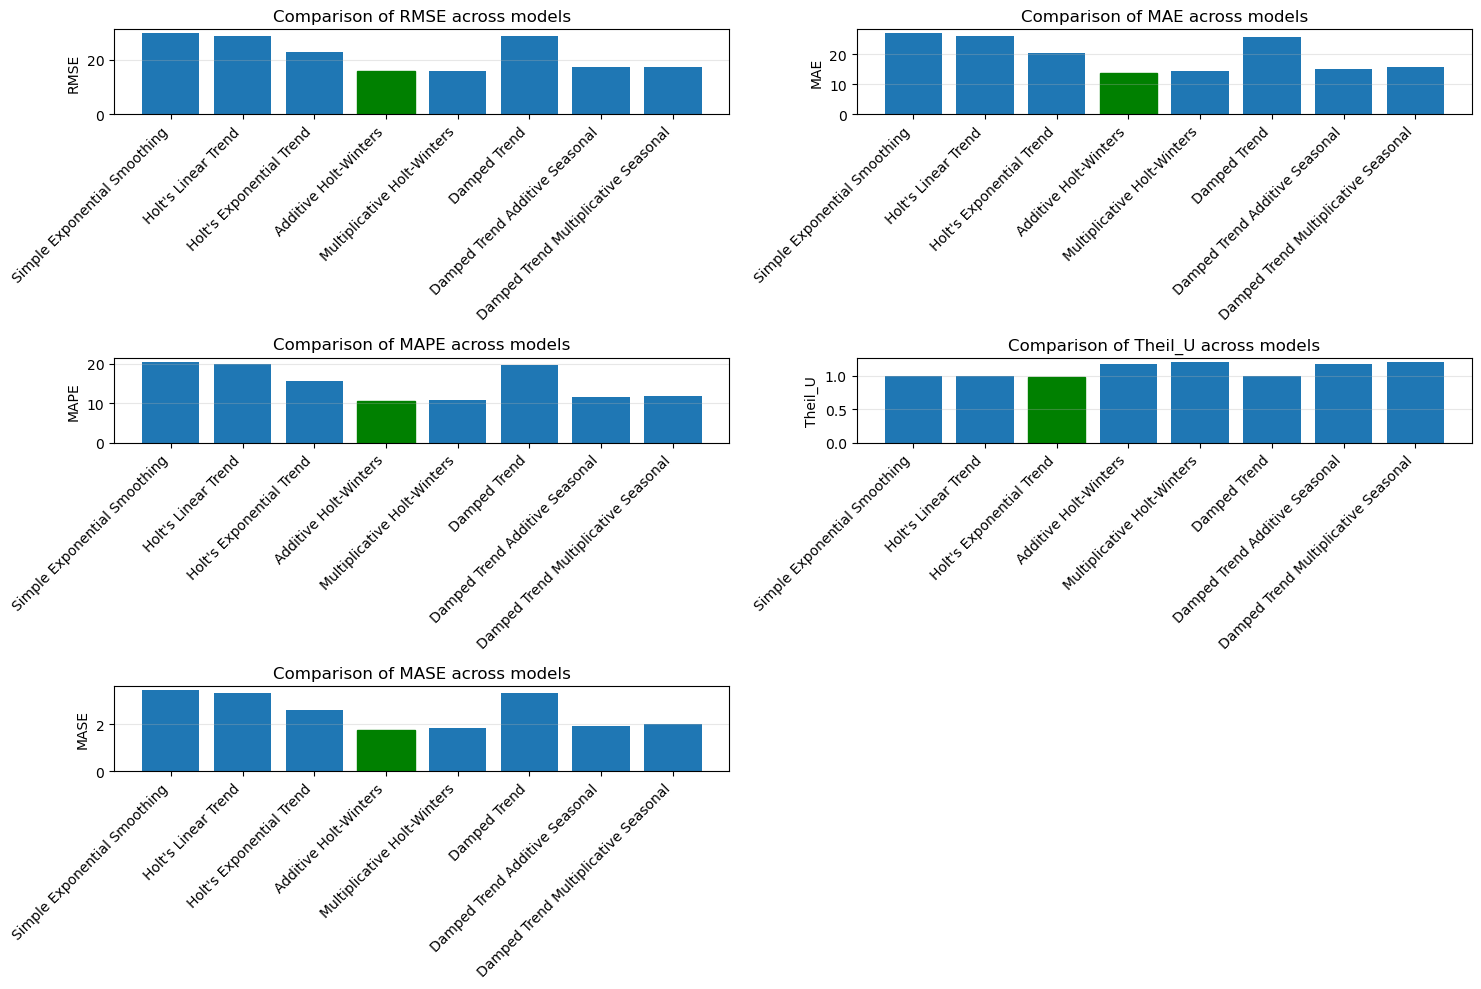

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import statsmodels.api as sm
from scipy.stats import rv_continuous, rv_discrete

# Load the merged dataset
data = pd.read_csv('/Users/leesunny/Desktop/S25_Time series/merged_monthly_data.csv')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Extract stock price data for univariate analysis
stock_data = data['stock_price'].dropna()

# Plot the stock price data
plt.figure(figsize=(12, 6))
plt.plot(stock_data)
plt.title('Airbnb Stock Price (Monthly)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Split the data into training and testing sets
train_size = int(len(stock_data) * 0.8)
train, test = stock_data[:train_size], stock_data[train_size:]
print(f"Training data: {train.index.min()} to {train.index.max()}, {len(train)} observations")
print(f"Testing data: {test.index.min()} to {test.index.max()}, {len(test)} observations")

# Define the ETS models to test
ets_models = [
    {"name": "Simple Exponential Smoothing", "trend": None, "seasonal": None, "seasonal_periods": None},
    {"name": "Holt's Linear Trend", "trend": "add", "seasonal": None, "seasonal_periods": None},
    {"name": "Holt's Exponential Trend", "trend": "mul", "seasonal": None, "seasonal_periods": None},
    {"name": "Additive Holt-Winters", "trend": "add", "seasonal": "add", "seasonal_periods": 12},
    {"name": "Multiplicative Holt-Winters", "trend": "add", "seasonal": "mul", "seasonal_periods": 12},
    {"name": "Damped Trend", "trend": "add", "seasonal": None, "seasonal_periods": None, "damped_trend": True},
    {"name": "Damped Trend Additive Seasonal", "trend": "add", "seasonal": "add", "seasonal_periods": 12, "damped_trend": True},
    {"name": "Damped Trend Multiplicative Seasonal", "trend": "add", "seasonal": "mul", "seasonal_periods": 12, "damped_trend": True}
]

# Function to calculate accuracy metrics
def calculate_metrics(actual, predicted):
    # Standard metrics
    rmse = math.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    
    # MAPE calculation (handling zeros)
    actual_nonzero = np.where(actual == 0, np.finfo(float).eps, actual)  # Avoid division by zero
    mape = np.mean(np.abs((actual - predicted) / actual_nonzero)) * 100
    
    # Additional metrics
    # 1. Theil's U Statistic
    changes_actual = np.diff(actual)
    changes_pred = np.diff(predicted)
    
    # Avoid division by zero in Theil's U
    nonzero_denom = np.sum(np.square(changes_actual)) != 0
    if nonzero_denom:
        theil_u = np.sqrt(np.sum(np.square(changes_pred - changes_actual)) / np.sum(np.square(changes_actual)))
    else:
        theil_u = np.nan
    
    # 2. MASE (Mean Absolute Scaled Error)
    # Use a simple naive forecast (t=t-1) as the baseline
    naive_errors = np.abs(np.diff(actual))
    scaled_errors = np.abs(actual - predicted) / np.mean(naive_errors) if len(naive_errors) > 0 else np.nan
    mase = np.mean(scaled_errors)
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'Theil_U': theil_u,
        'MASE': mase
    }

# Run models and evaluate
results = []

for model_spec in ets_models:
    model_name = model_spec.pop("name")
    print(f"Fitting {model_name}...")
    
    # Add damped_trend parameter if it exists
    damped_trend = model_spec.pop("damped_trend", False)
    
    # Fit the model
    try:
        model = ExponentialSmoothing(train, **model_spec, damped_trend=damped_trend).fit()
        
        # Generate predictions
        predictions = model.forecast(len(test))
        
        # Calculate metrics
        metrics = calculate_metrics(test.values, predictions.values)
        
        # Store results
        result = {"Model": model_name}
        result.update(metrics)
        results.append(result)
        
        # Plot actual vs predicted
        plt.figure(figsize=(12, 6))
        plt.plot(train.index, train, label='Training Data')
        plt.plot(test.index, test, label='Actual Test Data')
        plt.plot(test.index, predictions, label='Forecast')
        plt.title(f'{model_name} - Actual vs Forecast')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'/Users/leesunny/Desktop/S25_Time series/{model_name.replace(" ", "_")}_forecast.png')
        plt.close()
        
    except Exception as e:
        print(f"Error fitting {model_name}: {e}")
        
# Create a results dataframe
results_df = pd.DataFrame(results)
print("\nModel Evaluation Results:")
print(results_df.to_string())

# Save results to CSV
results_df.to_csv('/Users/leesunny/Desktop/S25_Time series/ets_model_results.csv', index=False)

# Find the best model for each metric
best_models = {}
metrics = ['RMSE', 'MAE', 'MAPE', 'Theil_U', 'MASE']

for metric in metrics:
    if metric in ['RMSE', 'MAE', 'MAPE', 'Theil_U', 'MASE']:  # Lower is better
        best_idx = results_df[metric].idxmin()
    else:  # Higher is better
        best_idx = results_df[metric].idxmax()
    
    best_models[metric] = results_df.loc[best_idx, 'Model']

print("\nBest models by metric:")
for metric, model in best_models.items():
    print(f"{metric}: {model}")

# Plot the metric comparison across models
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    bars = plt.bar(results_df['Model'], results_df[metric])
    plt.title(f'Comparison of {metric} across models')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(metric)
    plt.grid(axis='y', alpha=0.3)
    
    # Highlight the best model
    if metric in ['RMSE', 'MAE', 'MAPE', 'Theil_U', 'MASE']:  # Lower is better
        best_idx = results_df[metric].idxmin()
    else:  # Higher is better
        best_idx = results_df[metric].idxmax()
    
    bars[best_idx].set_color('green')

plt.tight_layout()
plt.show()

### Why using Theil's U statistics and MASE
- Theil's U Statistic: This metric measures the accuracy of forecasts relative to the "naïve" forecast method. A value less than 1 indicates the forecasting technique is better than simply using the last observed value, while a value greater than 1 indicates the model performs worse than the naïve approach. Theil's U is particularly valuable for stock price forecasting because it's scale-independent, allowing comparison across different time periods and specifically evaluates the model's ability to predict directional changes, which is crucial for financial time series.
- Mean Absolute Scaled Error (MASE): This metric compares the model's forecast errors with those of a simple naïve forecast. It's also scale-independent, allowing fair comparison across different price levels and handle intermittent deand patterns well, which can occur in volaile markets.

### Which models work best?
The **Additive Holt-Winters** model emerges as the overall best performer with:

- Lowest RMSE (15.83)
- Lowest MAE (13.72)
- Lowest MAPE (10.50%)
- Competitive MASE (1.76)

Reason:

- Seasonal Component Importance: Both top-performing models incorporate seasonality, indicating that Airbnb's stock price exhibits cyclical patterns. This aligns with Airbnb's business model, which is heavily influenced by travel seasons and holiday patterns.
- Trend + Seasonality Combination: The Holt-Winters approach combines trend and seasonal components, capturing both the directional movement and recurring patterns in Airbnb's stock. Simple models without seasonality (like Simple Exponential Smoothing) perform significantly worse.
- Additive vs Multiplicative: The slightly better performance of the additive seasonal model suggests that Airbnb's seasonal fluctuations maintain relatively consistent amplitude rather than scaling with the level of the series.

The superior performance of the Additive Holt-Winters model provides a strong case for using this approach for short to medium-term forecasting, while remaining cautious about the model's ability to predict exact turning points in the stock's trajectory.